In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import random
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data, reduce_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed, 6)

In [5]:
len(data_tr[2])

75208

In [6]:
print(np.mean(data_tr[2]))
data_tr = reduce_dataset(data_tr, len(train_onto), 1600, data_vl)
print(np.mean(data_tr[2]))

0.21727741729603234


0.20078125


In [7]:
type(data_vl)

list

In [8]:
len(data_tr[2])

64000

In [9]:
len(data_te_tr[2])

37564

In [10]:
print(np.mean(data_te_tr[2]))
data_te_tr = reduce_dataset(data_te_tr, len(test_onto), 1400, [idx_te_te, X_te_te, y_te_te])
print(np.mean(data_te_tr[2]))

0.21858694494728995


0.19907142857142857


In [11]:
len(data_te_tr[2])

28000

In [12]:
idx_te_te.extend(data_te_vl[0])
X_te_te.extend(data_te_vl[1])
y_te_te.extend(data_te_vl[2])

In [13]:
len(y_te_te)

2436

In [14]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
# print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.20078125
0.20701168614357263

0.19907142857142857
0.1990968801313629


In [15]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32
random.seed(seed)
T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
        batch_size=batch_size)

# trained_reasoner.load_state_dict(T.load('local/out/exp/20240723T203043/reasoner.pt'))


created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 0013/2000 | loss 0.7202 | elapsed 0.13s

train epoch 00/15 | batch 2001/2000 | loss 0.7219 | val loss 0.7207 | acc 0.2068 | f1 0.3427 | prec 0.2068 | recall 0.9990 | roc auc 0.5332 | pr auc 0.2351 | elapsed 16.41s
train epoch 01/15 | batch 2001/2000 | loss 0.5591 | val loss 0.4655 | acc 0.8015 | f1 0.1120 | prec 0.7595 | recall 0.0605 | roc auc 0.6956 | pr auc 0.3813 | elapsed 59.01s
train epoch 02/15 | batch 2001/2000 | loss 0.4225 | val loss 0.4206 | acc 0.8180 | f1 0.3344 | prec 0.6887 | recall 0.2208 | roc auc 0.7924 | pr auc 0.5574 | elapsed 58.91s
train epoch 03/15 | batch 2001/2000 | loss 0.3180 | val loss 0.3802 | acc 0.8548 | f1 0.5433 | prec 0.7782 | recall 0.4173 | roc auc 0.8339 | pr auc 0.6773 | elapsed 60.31s
train epoch 04/15 | batch 2001/2000 | loss 0.2459 | val loss 0.3565 | acc 0.8737 | f1 0.6263 | prec 0.8086 | recall 0.5111 | roc auc 0.8554 | pr auc 0.7350 | elapsed 57.73s
train epoch 05/15 | batch 2001/2000 | loss 0.2025 | val loss 0.3326 | acc 0.8811 | f1 0.6655 | prec 0.7963 | recall 0.5716 | roc auc 0.

In [16]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te_tr, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner


train epoch 00/10 | batch 876/875 | loss 1.4097 | val loss 1.4097 | acc 0.5790 | f1 0.3783 | prec 0.2679 | recall 0.6435 | roc auc 0.6710 | pr auc 0.4765 | elapsed 9.30s
train epoch 01/10 | batch 876/875 | loss 1.2088 | val loss 0.9784 | acc 0.6666 | f1 0.4374 | prec 0.3293 | recall 0.6511 | roc auc 0.7339 | pr auc 0.5418 | elapsed 20.10s
train epoch 02/10 | batch 876/875 | loss 0.8357 | val loss 0.6668 | acc 0.7516 | f1 0.5189 | prec 0.4223 | recall 0.6729 | roc auc 0.7965 | pr auc 0.6209 | elapsed 20.45s
train epoch 03/10 | batch 876/875 | loss 0.5760 | val loss 0.4631 | acc 0.8237 | f1 0.6114 | prec 0.5448 | recall 0.6964 | roc auc 0.8507 | pr auc 0.7076 | elapsed 20.31s
train epoch 04/10 | batch 876/875 | loss 0.4104 | val loss 0.3370 | acc 0.8728 | f1 0.6923 | prec 0.6678 | recall 0.7187 | roc auc 0.8912 | pr auc 0.7854 | elapsed 19.86s
train epoch 05/10 | batch 876/875 | loss 0.3078 | val loss 0.2592 | acc 0.9062 | f1 0.7592 | prec 0.7768 | recall 0.7424 | roc auc 0.9198 | pr auc

In [17]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240730T142558


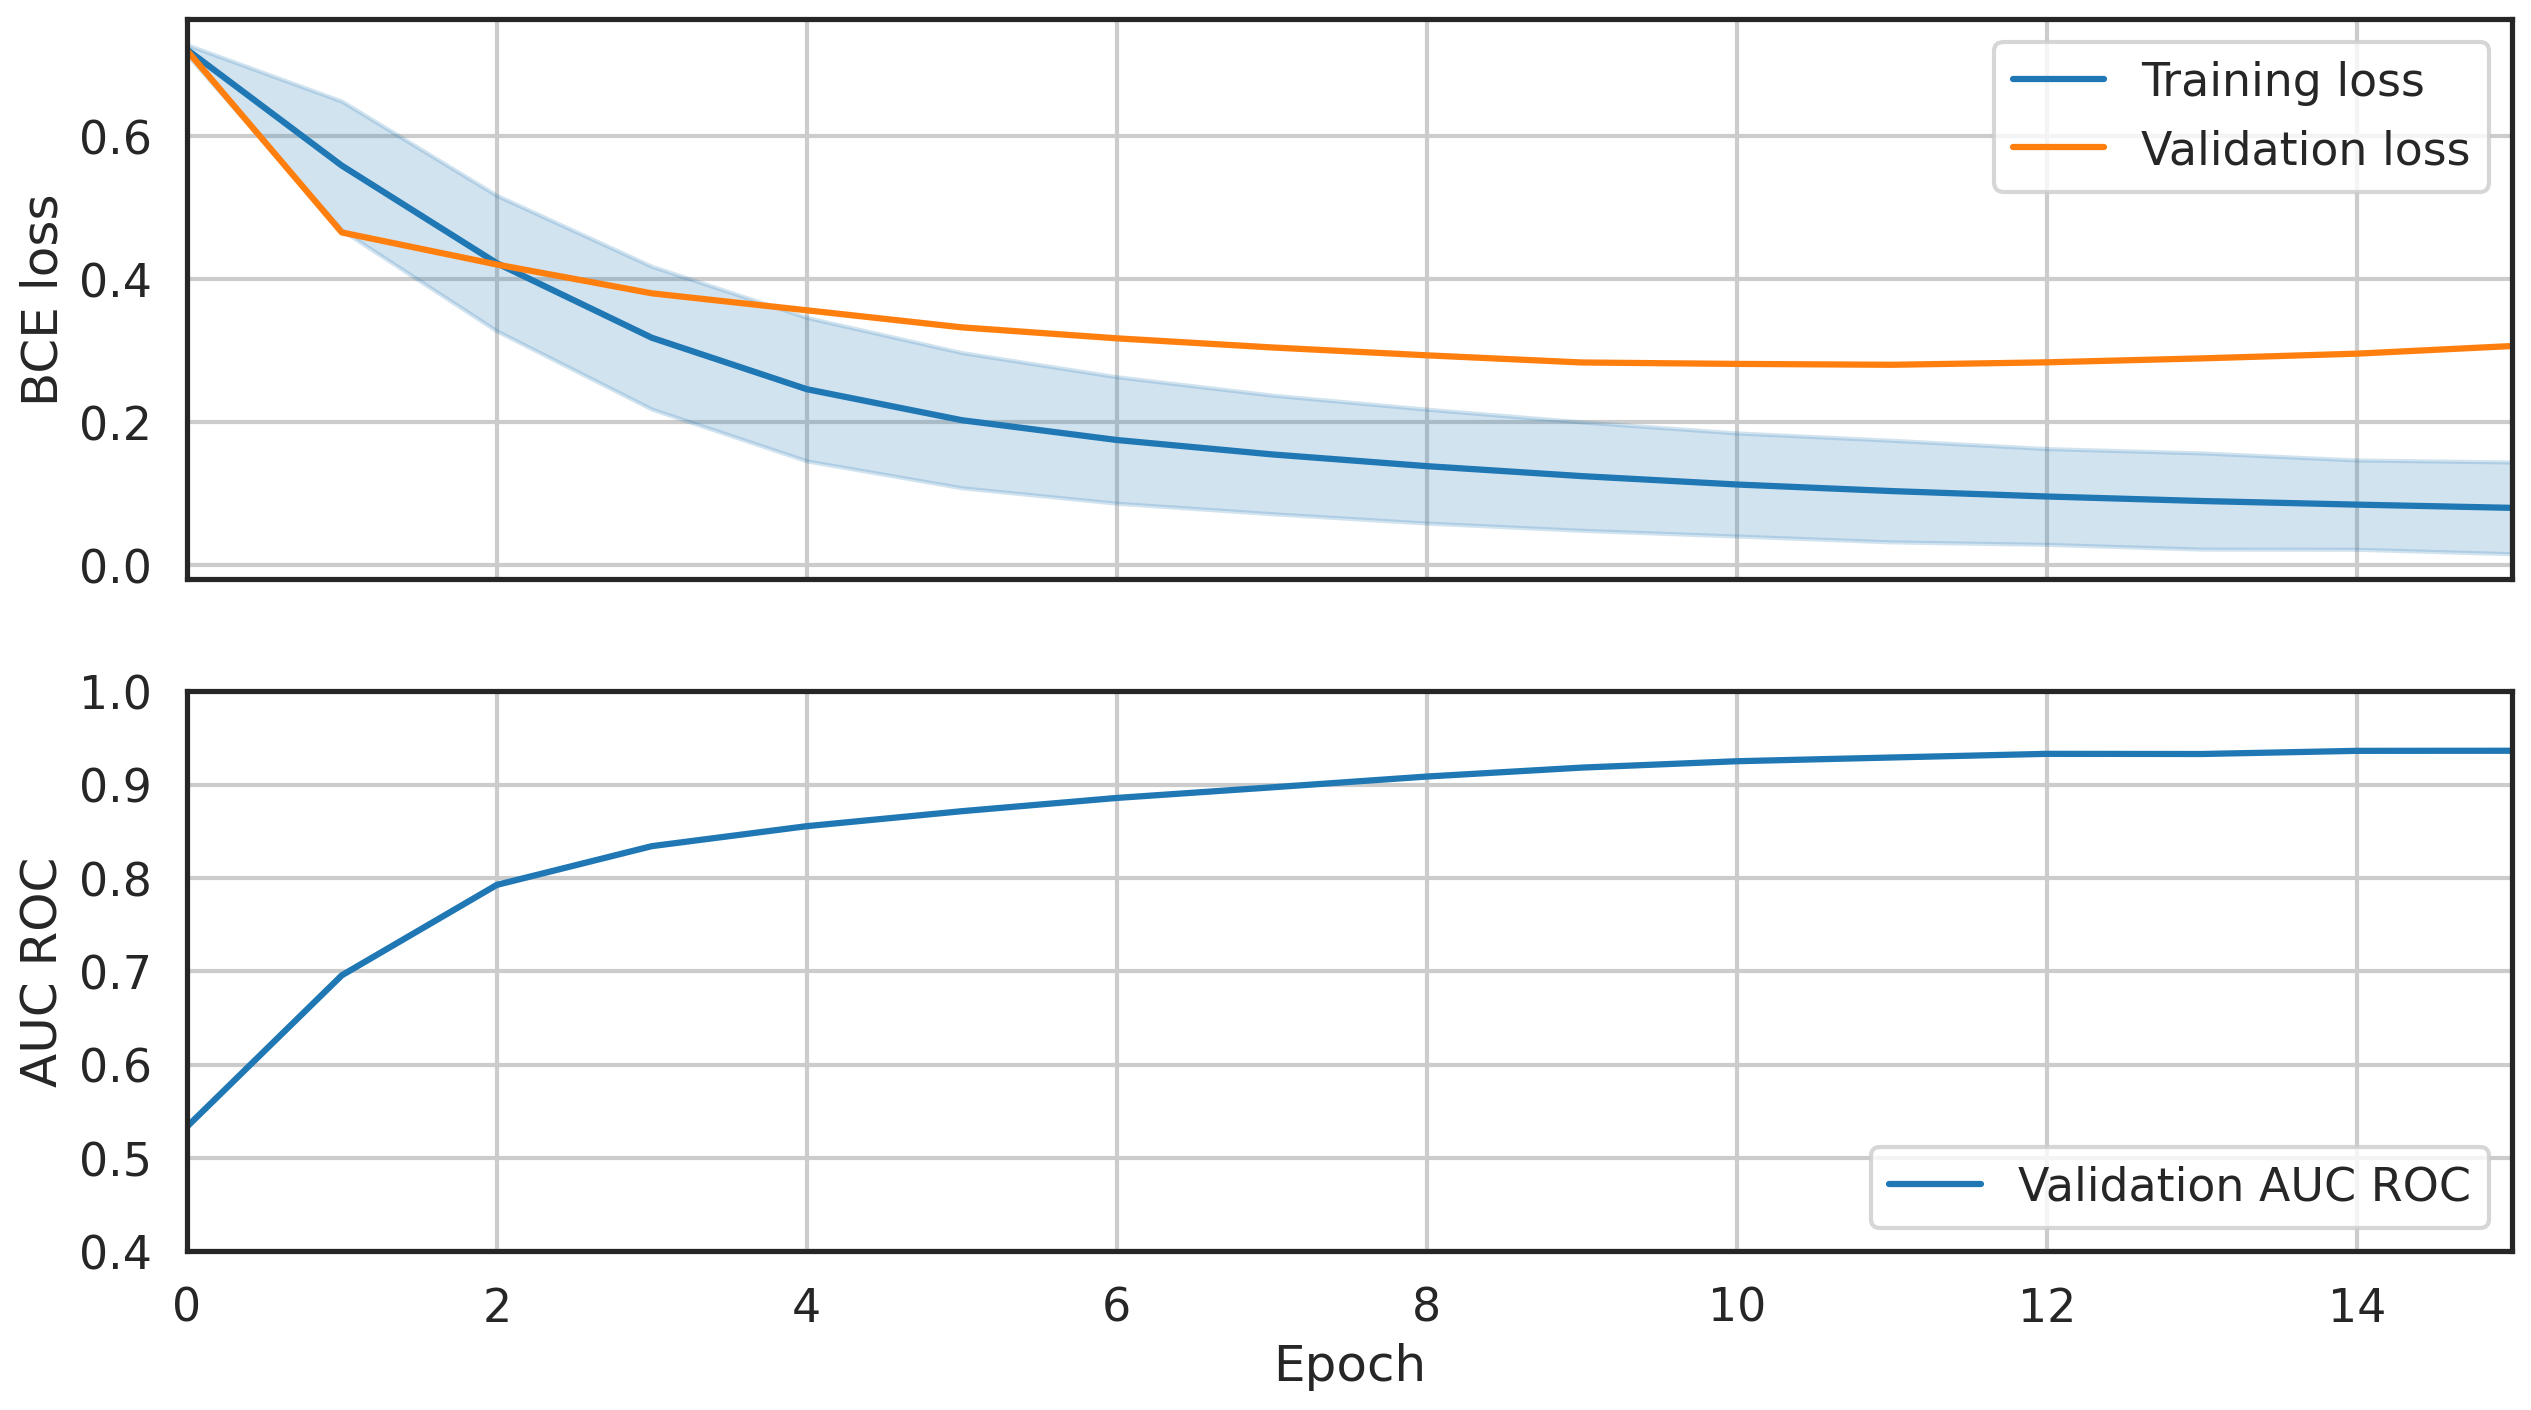

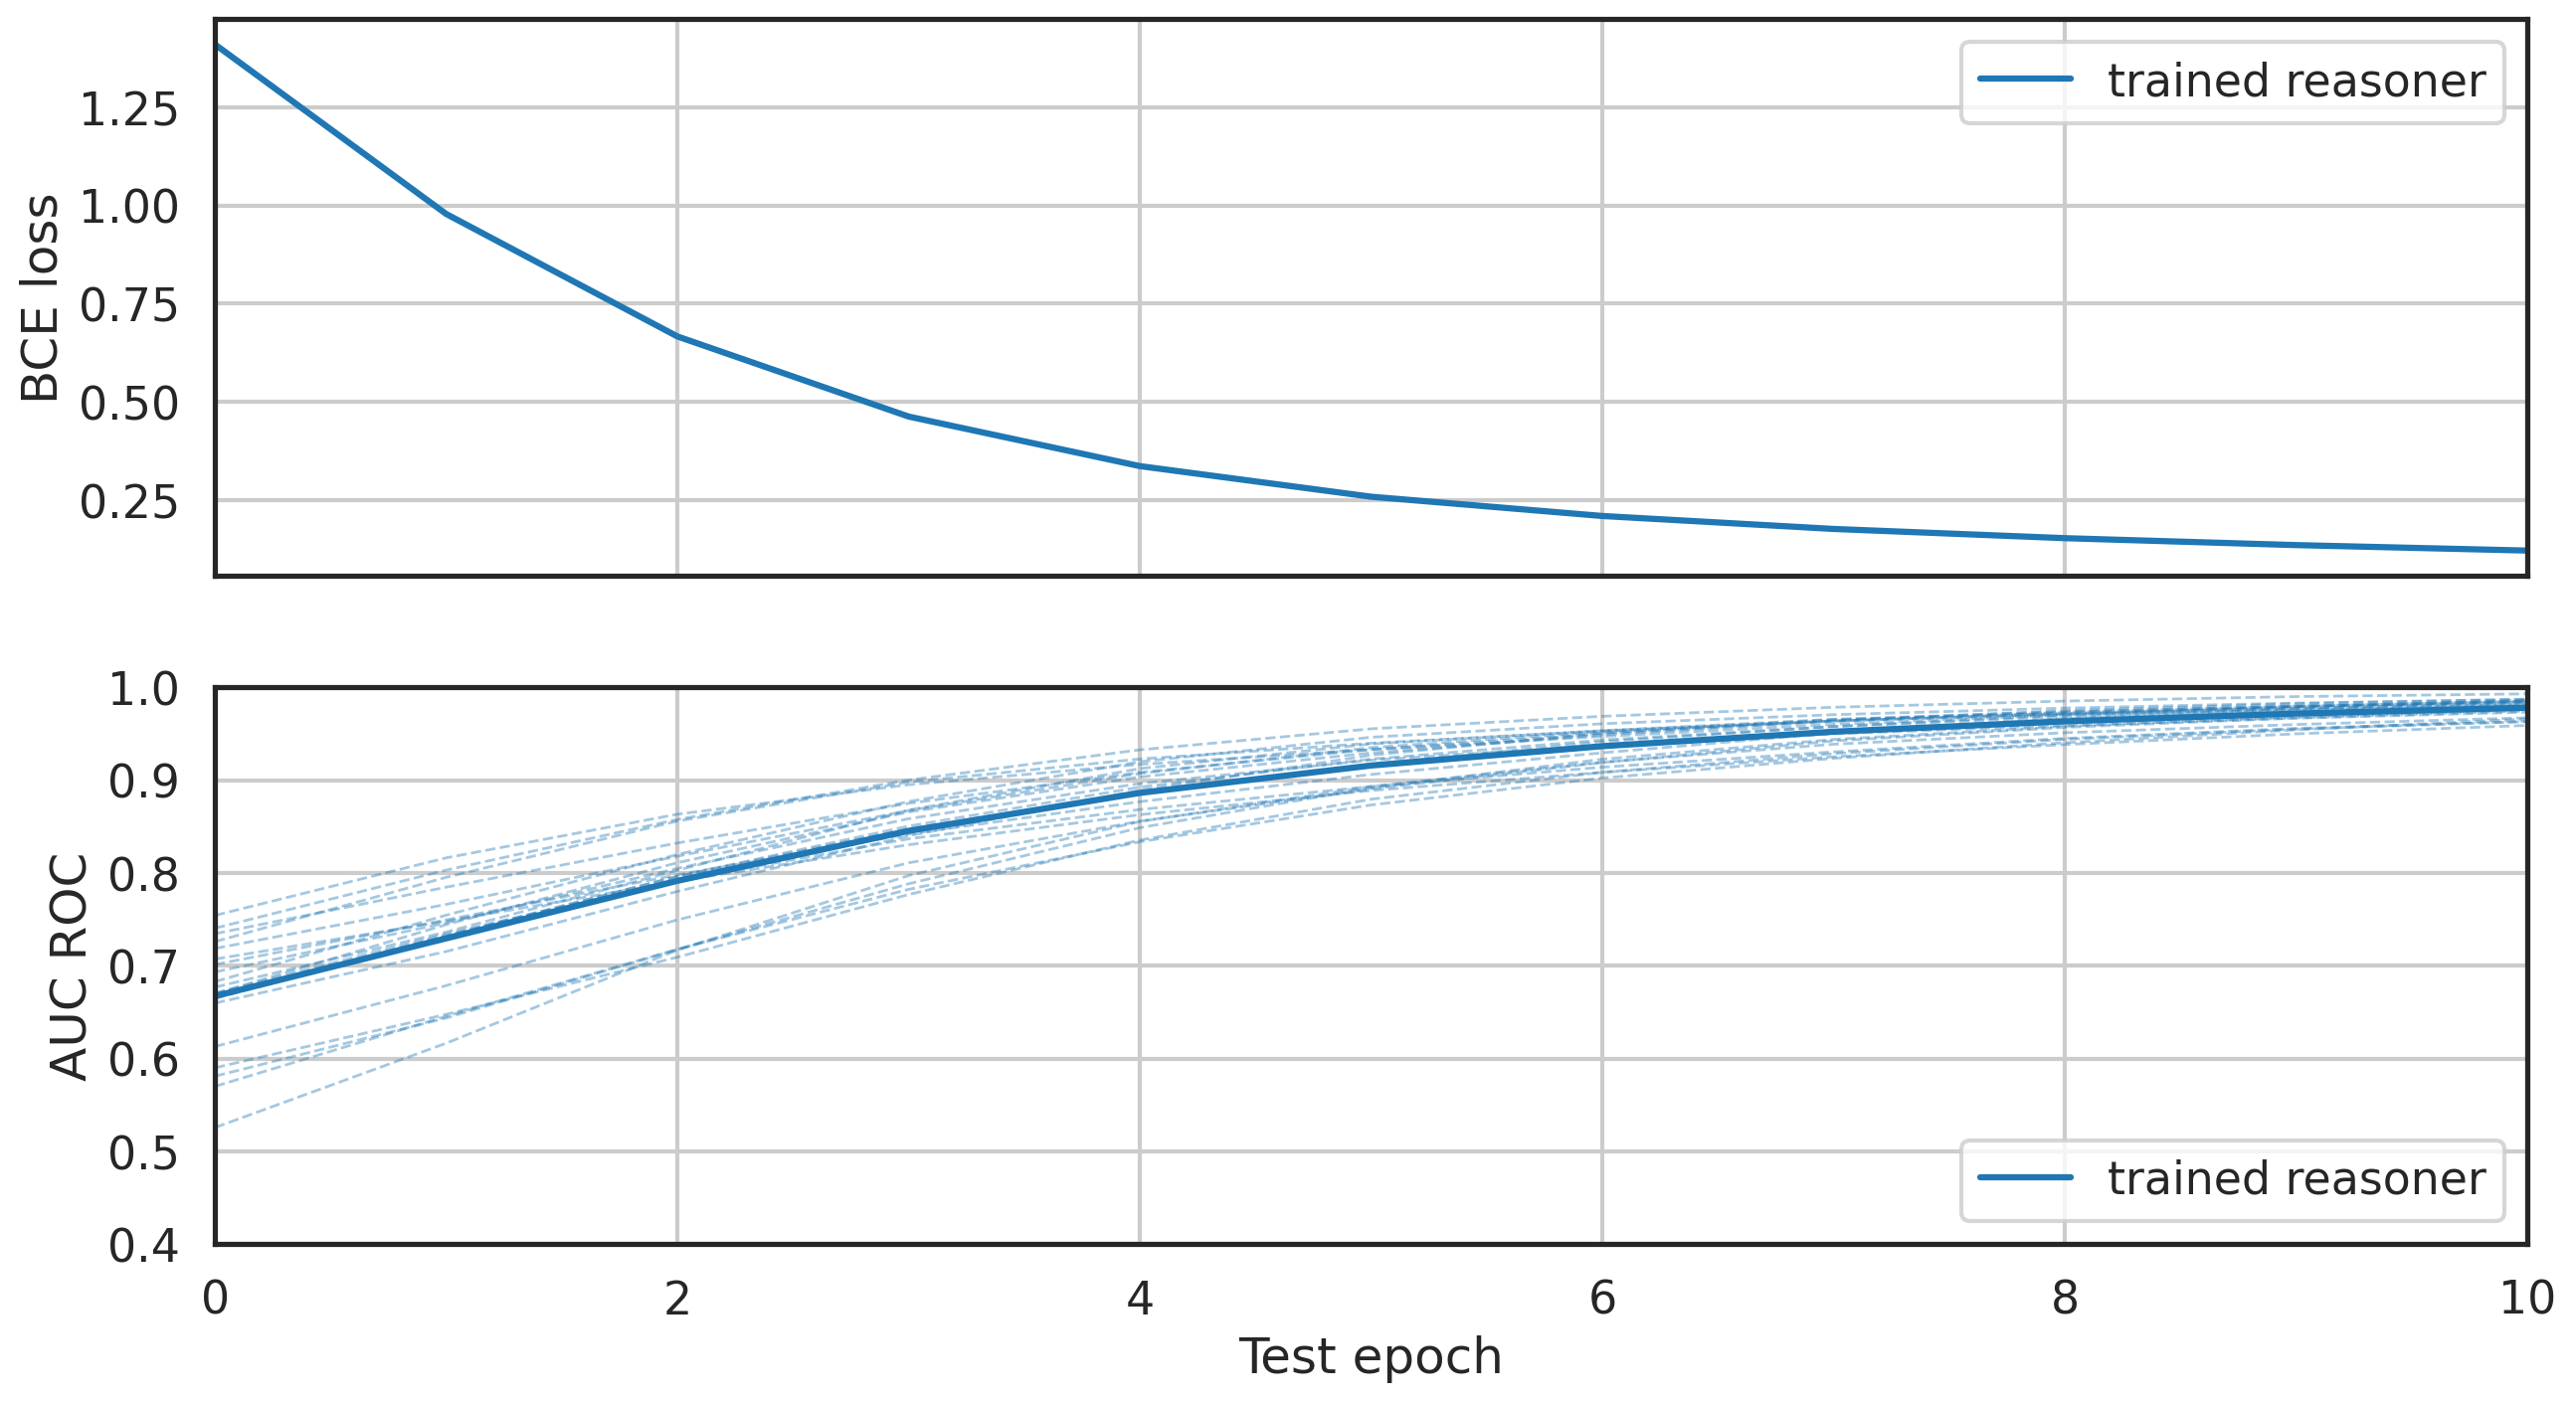

             mean       std     micro
acc      0.882976  0.045945  0.883005
prec     0.735006  0.140750  0.731481
recall   0.637738  0.144546  0.651546
f1       0.675529  0.123649  0.689204
auc_roc  0.875078  0.067039  0.879389
auc_pr   0.753721  0.128369  0.766292


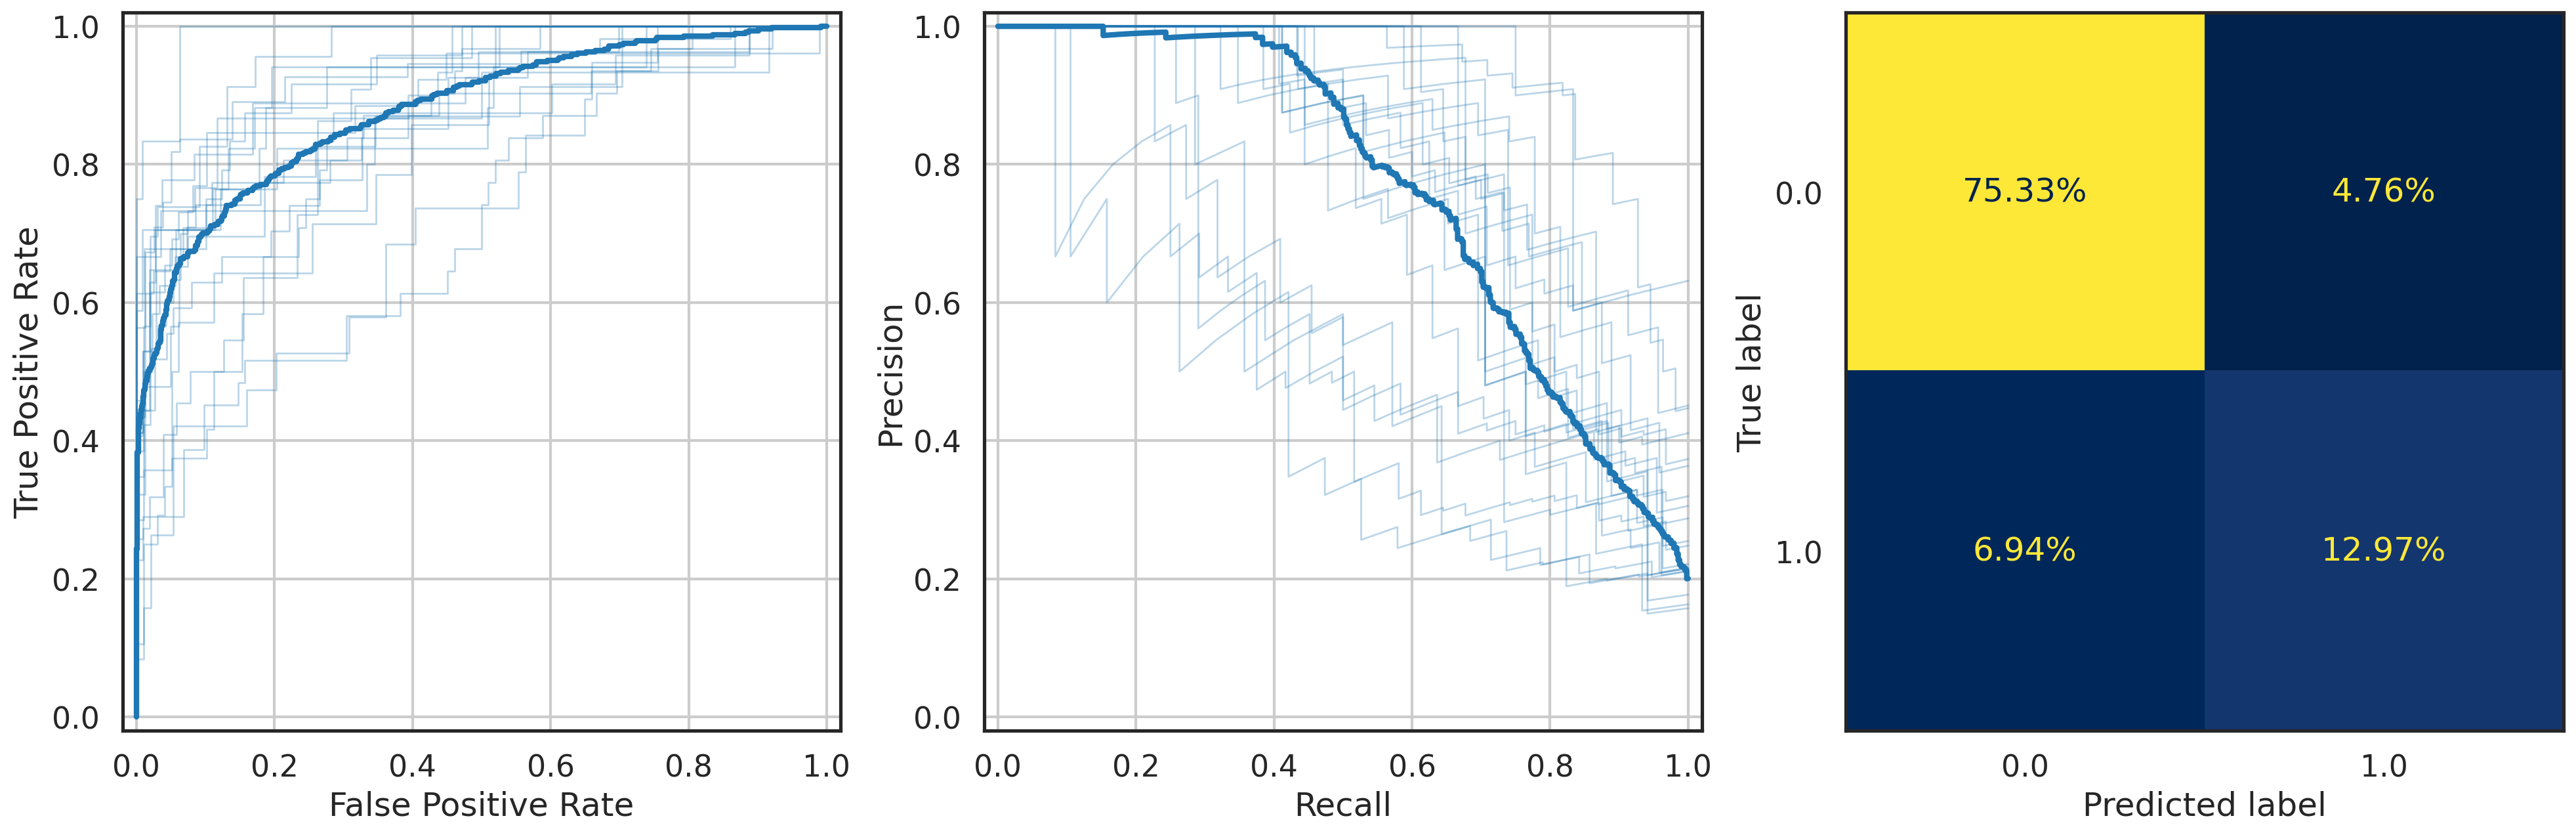

In [18]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [19]:
import random

In [20]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [21]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []

losses_bot_concept_self = []
diffs_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )


In [22]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])


Double Negation:
  Mean Loss: 0.282472
  Std Dev Loss: 0.032538
  Mean Diff: 0.573952
  Std Dev Diff: 0.097619

Duality of Top and Bottom:
  Mean Loss: 0.376950
  Std Dev Loss: 0.000000
  Mean Diff: 0.677282
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.126977
  Std Dev Loss: 0.032581
  Mean Diff: 0.315406
  Std Dev Diff: 0.086891

Associativity:
  Mean Loss: 0.035018
  Std Dev Loss: 0.012064
  Mean Diff: 0.079232
  Std Dev Diff: 0.025890

Commutativity:
  Mean Loss: 0.037621
  Std Dev Loss: 0.012832
  Mean Diff: 0.088039
  Std Dev Diff: 0.032585

Contradiction:
  Mean Loss: 0.369818
  Std Dev Loss: 0.021127
  Mean Diff: 0.827172
  Std Dev Diff: 0.070509

Identity with Top:
  Mean Loss: 0.157281
  Std Dev Loss: 0.036396
  Mean Diff: 0.373149
  Std Dev Diff: 0.107470

Absorption by Bottom:
  Mean Loss: 0.408779
  Std Dev Loss: 0.017973
  Mean Diff: 0.792435
  Std Dev Diff: 0.030800

Top Concept Subsumption:
  Mean Loss: 0.001202
  Std Dev Loss: 0.001812
  Mean Diff: N/A
  Std De